### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.color import gray2rgb

### Load MINST dataset

In [2]:
# get dataset and split it into two datasets (training, testing)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Data preprocessing

In [3]:
# preprocessing the data
def preprocess_data(X, y):
    # normalization
    X = X.astype("float32") / 255
    X = np.array([gray2rgb(img) for img in X])
    # one-hot encoding
    y = np_utils.to_categorical(y)
    return X, y

X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

In [4]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 28, 28, 3)
X_test shape: (10000, 28, 28, 3)


In [5]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


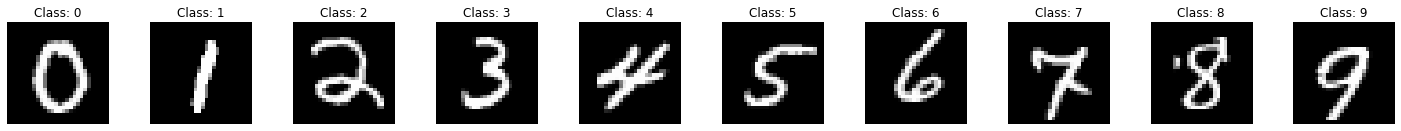

In [6]:
# set random seed
np.random.seed(100)

# choose some examples to visualize
examples = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    examples.append(np.random.choice(all_indexes))

# show examples
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[examples][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[examples][i])}')
    ax.axis('off')

### Black-box model

In [7]:
import keras
import tensorflow as tf

In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=np.shape(X_train)[1:]),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),        
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dropout (Dropout)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,986
Trainable params: 54,986
Non-trainable params: 0
____________________________________________________

In [10]:
# train the model
model.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=0.1)

Epoch 1/5
5400/5400 [==============================] - 18s 3ms/step - loss: 0.1991 - accuracy: 0.9396 - val_loss: 0.0752 - val_accuracy: 0.9800
Epoch 2/5
5400/5400 [==============================] - 18s 3ms/step - loss: 0.1044 - accuracy: 0.9673 - val_loss: 0.0643 - val_accuracy: 0.9817
Epoch 3/5
5400/5400 [==============================] - 19s 3ms/step - loss: 0.0846 - accuracy: 0.9737 - val_loss: 0.0551 - val_accuracy: 0.9852
Epoch 4/5
5400/5400 [==============================] - 19s 4ms/step - loss: 0.0757 - accuracy: 0.9765 - val_loss: 0.0519 - val_accuracy: 0.9847
Epoch 5/5
5400/5400 [==============================] - 19s 3ms/step - loss: 0.0678 - accuracy: 0.9795 - val_loss: 0.0508 - val_accuracy: 0.9858


In [11]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test loss:", '\t', loss)
print("Test accuracy:", '\t', accuracy)

Test loss: 	 0.051907557994127274
Test accuracy: 	 0.984000027179718


### Explanation

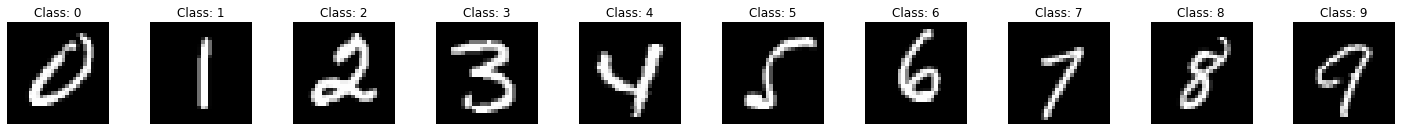

In [12]:
# set random seed
np.random.seed(10)

# images to classify and explain
to_explain = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    to_explain.append(np.random.choice(all_indexes))

fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[to_explain][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[to_explain][i])}')
    ax.axis('off')

#### 1. LIME

In [13]:
# import lime library
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [14]:
# create the explainer object
lime_explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [ ]:
# generate the explanations
explanations = [
    lime_explainer.explain_instance(
        X_test[to_explain][i], 
        classifier_fn=model.predict, 
        top_labels=10, 
        hide_color=0, 
        num_samples=10000,
        segmentation_fn=segmenter
    ) for i in range(10)
]

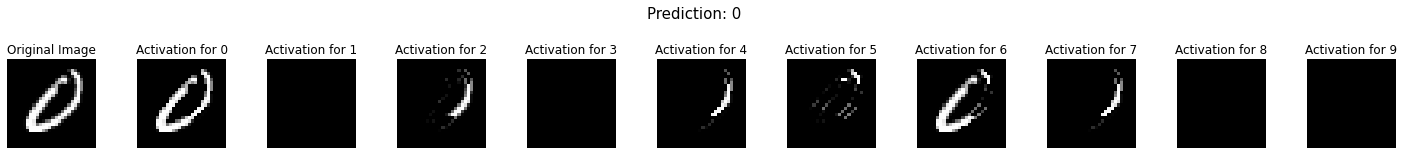

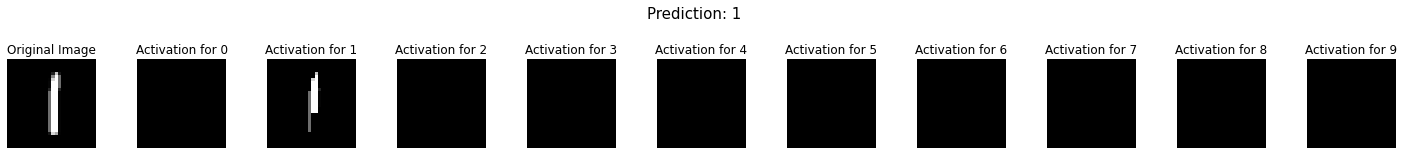

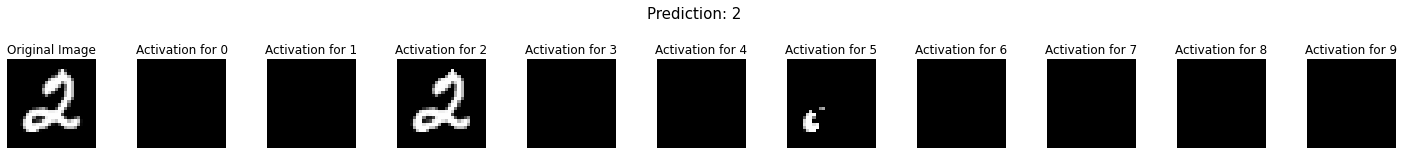

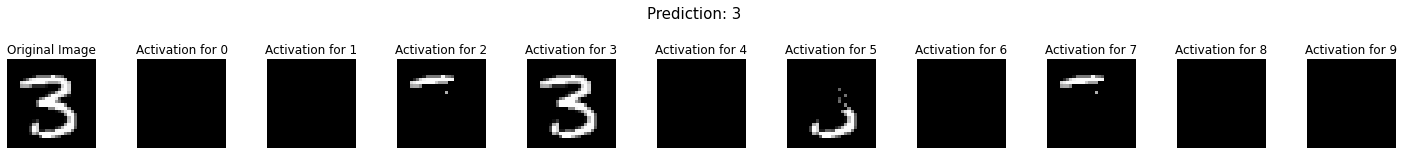

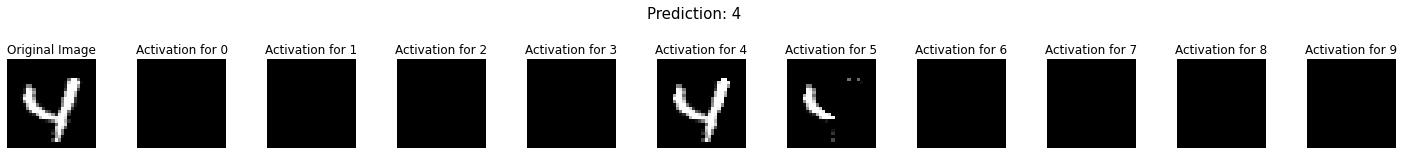

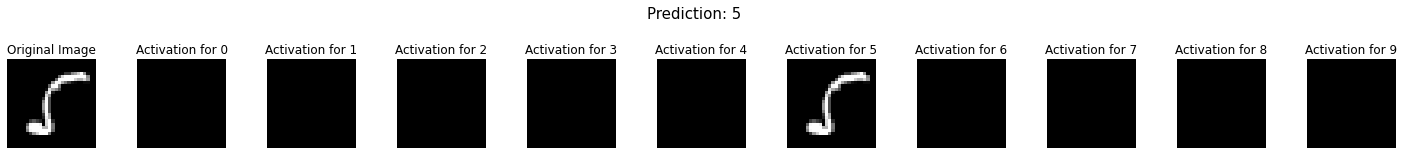

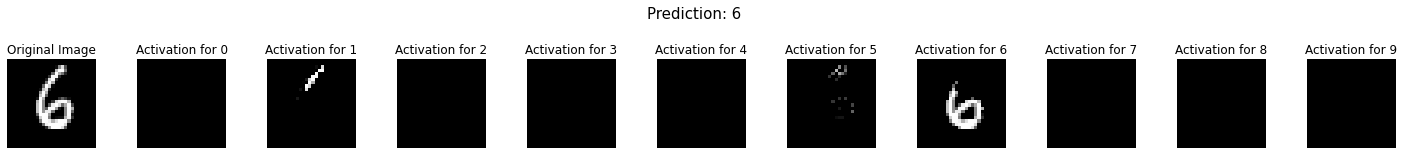

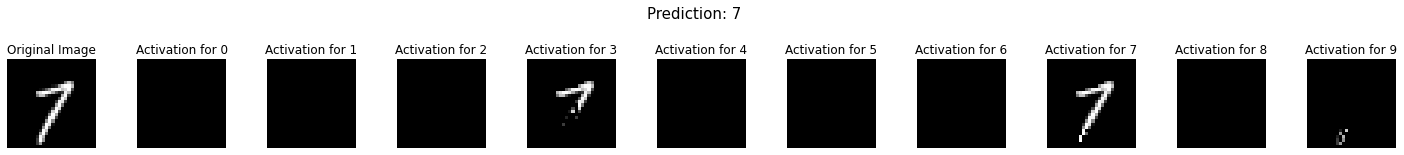

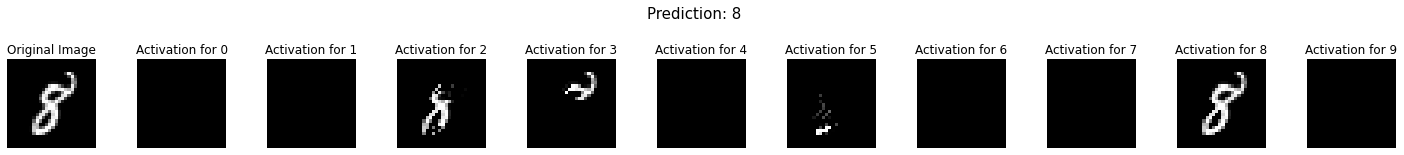

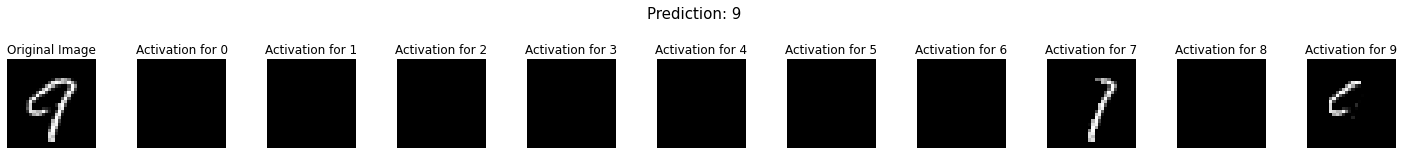

In [16]:
# plot the explanations
for i_exp, explanation in enumerate(explanations):
    fig, axes = plt.subplots(1, 11, figsize=(20, 3))
    fig.tight_layout()
    for i, c_ax in enumerate(axes.flatten()):
        if i == 0:
            c_ax.imshow(X_test[to_explain][i_exp])
            c_ax.set_title(f'Original Image')
            c_ax.axis('off')
        else:
            temp, mask = explanation.get_image_and_mask(i - 1, positive_only=True, hide_rest=True, min_weight=0.02)
            c_ax.imshow(temp)
            c_ax.set_title(f'Activation for {i - 1}')
            c_ax.axis('off')
    fig.suptitle(f'Prediction: {explanation.top_labels[0]}', fontsize=15)

#### 2. SHAP

In [17]:
# import shap library
import shap
shap.initjs()

In [18]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [19]:
# explain predictions of the model on three images
shap_explainer = shap.DeepExplainer(model, background)
shap_values = shap_explainer.shap_values(X_test[to_explain])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Prediction: 0


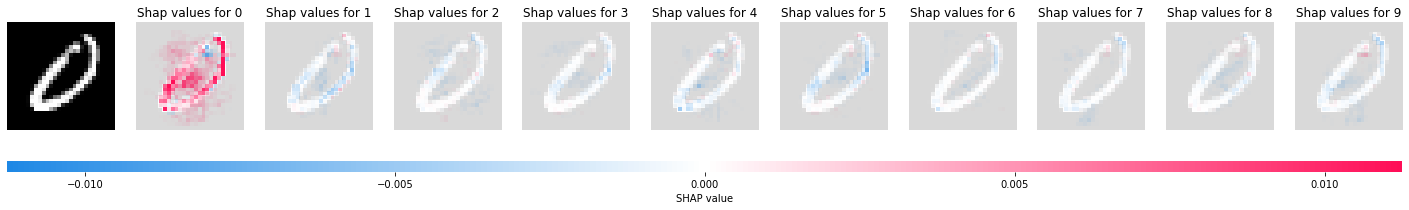

Prediction: 1


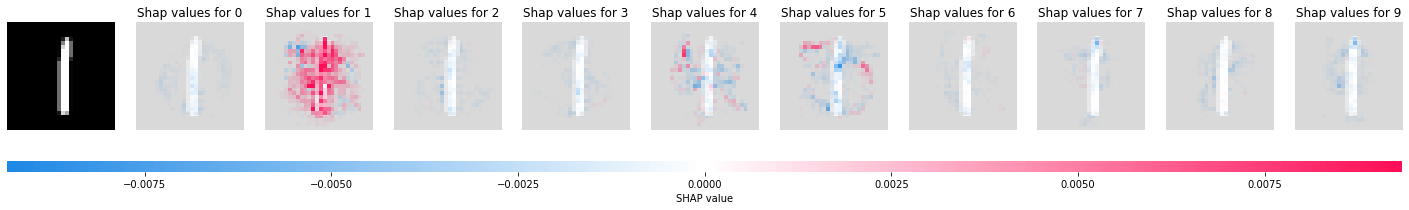

Prediction: 2


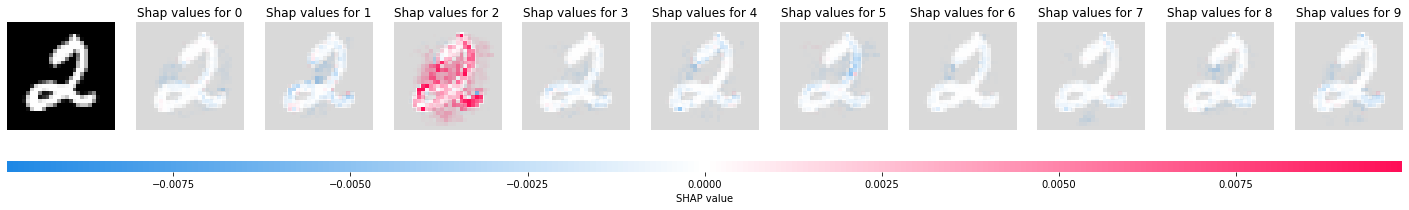

Prediction: 3


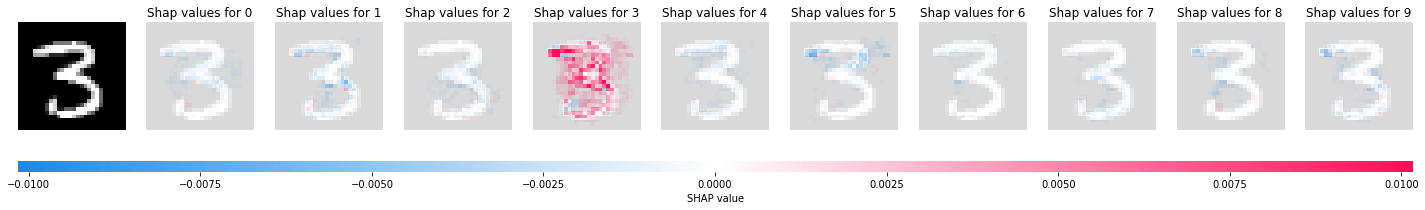

Prediction: 4


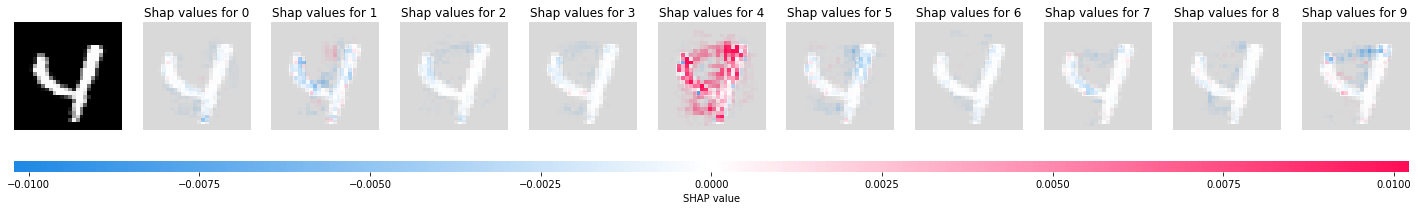

Prediction: 5


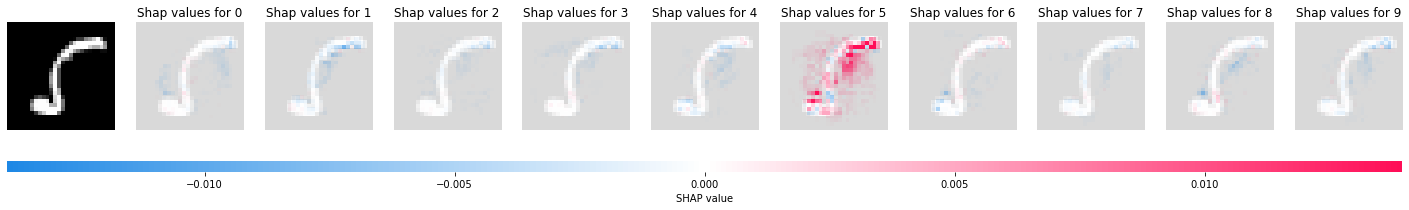

Prediction: 6


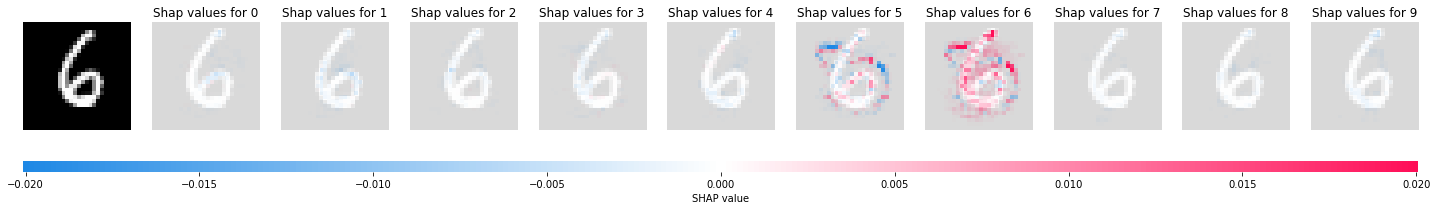

Prediction: 7


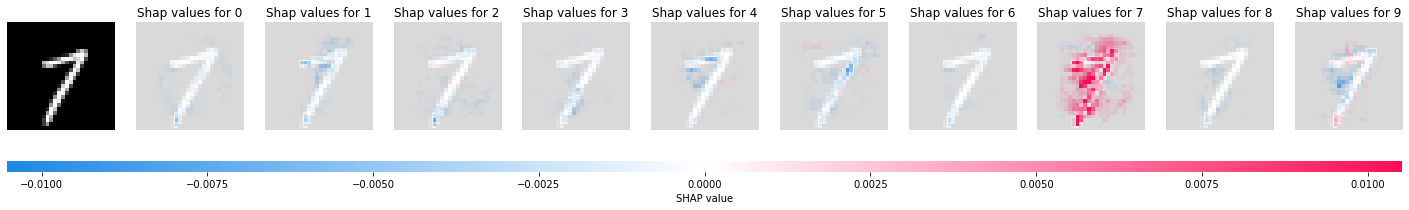

Prediction: 8


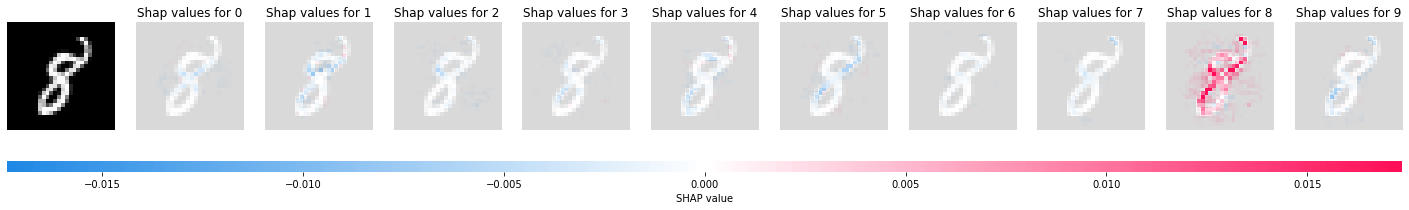

Prediction: 9


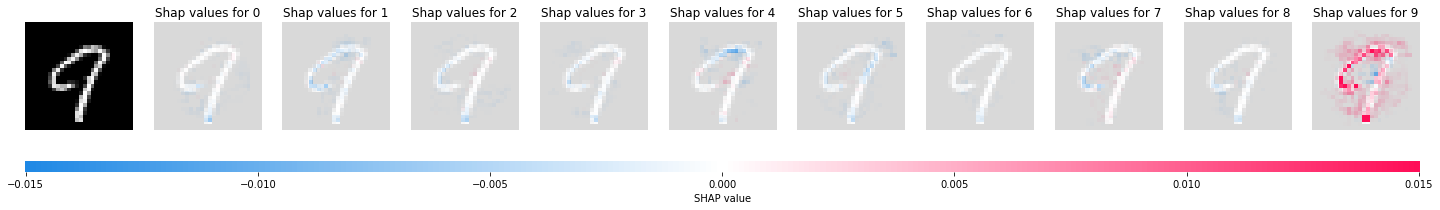

In [20]:
# plot the explanations
for i in range(10):
    shap.image_plot(
        list(np.array(shap_values)[:, i:i+1]), 
        X_test[to_explain[i:i+1]], 
        width=25, show=False, 
        labels=[f'Shap values for {sh_v}' for sh_v in range(10)]
    )
    print('Prediction:', np.argmax(model.predict(X_test[to_explain[i:i+1]], verbose=False)[0]))
    plt.show()